In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instedad
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on Tori

This notebook shows how define and evaluate kernels on the two-dimensional torus $\mathbb{T}^2$.

Any torus $\mathbb{T}^d$ is a *product manifold* $\mathbb{T}^d = \mathbb{T}^1 \times \ldots \times \mathbb{T}^1$ where $\mathbb{T}^1 = \mathbb{S}_1$ is the circle.
So this notebook also shows the basics of working with product manifolds.

**Note:** the kind of torus we consider here (product of circles) is the *flat torus*.
Its Riemannian geometry is different from the Riemannian geometry that the often-visualized donut shape inherits from the ambient $\mathbb{R}^3$.
Rather than that, its Riemannian geometry is the geometry of the product manifold while the geometry of each individual circle is inhereted from the ambient $\mathbb{R}^2$ space.
It follows that $\mathbb{T}^d$ can be embedded in $\mathbb{R}^{2 d}$ and the Riemannian geometry this embedding inherits from the ambient $\mathbb{R}^{2 d}$ coincides with the Riemannian geometry of the flat torus.
It is useful to think of the flat torus as the square ($d$-dimensional hypercube) with opposite sides glued together.
Another way to think about the flat torus is that functions on the flat torus are exactly $2 \pi$-periodic functions (in each of the variables) in $\mathbb{R}^d$.

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels
# Import the spaces and an appropriate kernel.
from geometric_kernels.spaces import Circle, ProductDiscreteSpectrumSpace
from geometric_kernels.kernels.geometric_kernels import MaternKarhunenLoeveKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO: Using numpy backend


TODO: num_eigen is levels or eigenfunctions?

## Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional torus $\mathbb{T}^2$.
We use `ProductDiscreteSpectrumSpace` which takes a number of `DiscreteSpectrumSpace` instances (e.g. `Circle()`) and constructs their product space. It also takes the `num_eigen` parameter determines the maximum number of eigenfunctions (TODO) the kernels on this space can use

In [3]:
torus = ProductDiscreteSpectrumSpace(Circle(), Circle(), num_eigen=30)

## Theory (Optional Reading)
### General Theory Behind `MaternKarhunenLoeveKernel` for Product Spaces

This builds on the general theory behind `MaternKarhunenLoeveKernel` for compact manifolds described in [Hypersphere.ipynb](./Hypersphere.ipynb).

Assume that $M$ is a product of compact Riemannian manifolds $M_j$, i.e. $M = M_1 \times \ldots \times M_m$.

`MaternKarhunenLoeveKernel` on $M$ is determined by the *eigenvalues* $\lambda_n \geq 0$ and *eigenfunctions* $f_n(\cdot)$ of the *Laplace–Beltrami operator* on $M$.

The **key idea** is that $\lambda_n, f_n$ can be obtained from the eigenvalues and eigenfunctions on $M_j$ therefore allowing to build `MaternKarhunenLoeveKernel` on the product space $M$ from the components you would use to build `MaternKarhunenLoeveKernel` on separate factors $M_j$.

In fact, all eigenfunctions on $M$ have form $f^{(1)}_{n_1}(\cdot_1) \ldots f^{(m)}_{n_m}(\cdot_m)$ where $f^{(j)}_{n_j}(\cdot)$ is the $n_j$-th eigenfunction on $M_j$.
These eigenfunctions correpond to the eigenvalues $\lambda^{(1)}_{n_1} + \ldots + \lambda^{(m)}_{n_m}$ where $\lambda^{(j)}_{n_j}$ is the $n_j$-th eigenvalue on $M_j$. See e.g. page 48 of the ["Analysis on Manifolds
via the Laplacian" by Yaiza Canzani](https://www.math.mcgill.ca/toth/spectral%20geometry.pdf).

## Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternKarhunenLoeveKernel`, you provide two parameters.
First, the `space`, in our case this is the `torus` we have just created above.
The second parameter, `num_eigenfunctions`, determines the number of terms in the approximation to the infinite series that defines the paper.



In [4]:
kernel = MaternKarhunenLoeveKernel(torus, 30)

In [5]:
params, state = kernel.init_params_and_state()
print('params:', params)
print('state:', state)

params: {'lengthscale': array(1.), 'nu': array(inf)}
state: {'eigenvalues_laplacian': array([[ 0],
       [ 1],
       [ 1],
       [ 2],
       [ 4],
       [ 4],
       [ 5],
       [ 5],
       [ 8],
       [ 9],
       [ 9],
       [10],
       [10],
       [13],
       [13],
       [16],
       [16],
       [17],
       [17],
       [18],
       [20],
       [20],
       [25],
       [25],
       [25],
       [25],
       [26],
       [26],
       [29],
       [29]]), 'eigenfunctions': <geometric_kernels.spaces.product.ProductEigenfunctions object at 0x7fb3d8069e80>}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [6]:
LENGTHSCALE = 0.5

params["lengthscale"] = np.array([LENGTHSCALE])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` (uniformly) random points on the torus $\mathbb{T}^2$

In [7]:
key = np.random.RandomState(1234)

key, xs = torus.random(key, 10)

print(xs)

[[1.2033522  2.24823221]
 [3.90882469 3.14784521]
 [2.7503245  4.29432427]
 [4.93455351 4.4780389 ]
 [4.90073254 2.3263541 ]
 [1.71274985 3.52609963]
 [1.73707615 3.16096475]
 [5.03831148 0.08650972]
 [6.02016711 4.85581287]
 [5.50364706 5.54579816]]


Now we evaluate the two kernel matrices.

In [8]:
kernel_mat_32  = kernel.K(params_32,  state, xs, xs)
kernel_mat_inf = kernel.K(params_inf, state, xs, xs)

Finally, we visualize these matrices using `imshow`.

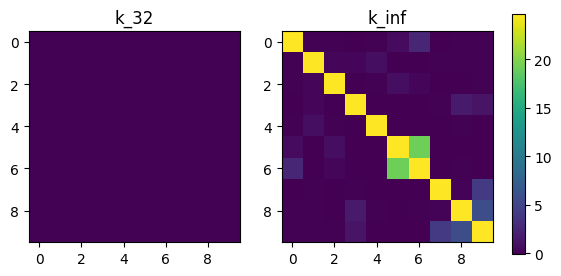

In [9]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

The torus $\mathbb{T}^2$ is one of the few manifolds we can easily visualize.
Because of this, beyond kernel matrices, we will plot the functions $k_{\nu, \kappa}(\text{pole}, \cdot)$.

In practice, we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
We represent the torus as the square whose sides are assumed to be glued.

We define `base_point` and `other_points` in the next cell.

In [10]:
base_point = np.array([[np.pi, 0.0]])

# define discretization
_NUM_PTS = 128

# generate a grid on the torus
x1s, x2s =  np.mgrid[0:2*np.pi:_NUM_PTS*1j, 0:2*np.pi:_NUM_PTS*1j]
other_points = np.c_[np.ravel(x1s), np.ravel(x2s)]

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [11]:
kernel_vals_32  = kernel.K(params_32,  state, base_point, other_points)
kernel_vals_inf = kernel.K(params_inf, state, base_point, other_points)

Finally, we are ready to plot the results.

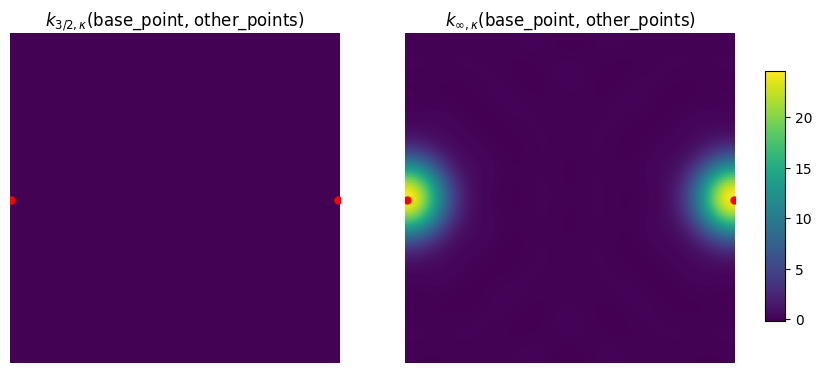

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize= (10, 5), nrows=1, ncols=2)

cmap = plt.get_cmap('viridis')

# find common range of values
minmin_vis = np.min([np.min(kernel_vals_32), np.min(kernel_vals_inf)])
maxmax_vis = np.max([np.max(kernel_vals_32), np.max(kernel_vals_inf)])

ax1.imshow( kernel_vals_32.reshape(_NUM_PTS, _NUM_PTS), vmin=minmin_vis, vmax=maxmax_vis, cmap=cmap)
ax2.imshow(kernel_vals_inf.reshape(_NUM_PTS, _NUM_PTS), vmin=minmin_vis, vmax=maxmax_vis, cmap=cmap)

# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()

# plot the base point
ax1.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax2.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)


ax1.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$')
ax2.set_title('$k_{\infty, \kappa}($base_point, other_points$)$')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

Notice how the kernel is getting "cut" on the left and continues on the right.
This is because the sides of this rectangle are actually glued together.

## Theory (Optional Reading)
### `MaternKarhunenLoeveKernel` on `ProductDiscreteSpectrumSpace` vs `ProductGeometricKernel`

In GeometricKernels, there is a concept of `ProductGeometricKernel`.
It allows you to define a kernel $k$ on $M$ by taking a product of kernels $k_j$ on $M_j$:
$$k(\cdot_1, \ldots, \cdot_m) = k_1(\cdot_1) \ldots k_m(\cdot_m).$$
Each $k_j$ could be `MaternKarhunenLoeveKernel` as well as something different (including the kernels on non-compact manifolds like hyperbolic spaces or manifolds of postive definite matrices).

**Importantly**, this allows you to have a separate length scale parameter for each of the factors, enabling, e.g. *automatic relevance determination* (ARD, cf. [Rasmussen and Williams (2006)](https://gaussianprocess.org/gpml/chapters/RW.pdf)).

However, for Matérn kernels, even if $\nu$ and $\kappa$ are the same for all $k_j$, the product kernel turns out to be different from the Matérn kernel on the product space whenever $\nu < \infty$.
If $\nu = \infty$, i.e. in the case of the heat (a.k.a. diffusion, squared exponential, RBF) kernel, the product kernel with same $\kappa$ and the kernel on the product space coincide.
This mirrors the standard Euclidean case.

We import the `ProductGeometricKernel` class

In [13]:
from geometric_kernels.kernels import ProductGeometricKernel

We define a new generic `product_kernel` as the product of two `MaternKarhunenLoeveKernel` on the `Circle`, initialize and set its paramters.

In [14]:
product_kernel = ProductGeometricKernel(MaternKarhunenLoeveKernel(Circle(), 30),
                                        MaternKarhunenLoeveKernel(Circle(), 30))
product_params, product_state = product_kernel.init_params_and_state()
print('params:', product_params)
print('state:', product_state)

product_params[0]["lengthscale"] = np.array([LENGTHSCALE])
product_params[1]["lengthscale"] = np.array([LENGTHSCALE])
product_params_32  = product_params.copy()
product_params_inf = product_params.copy()
del product_params
product_params_32[0]["nu"]  = np.array([3/2])
product_params_32[1]["nu"]  = np.array([3/2])
product_params_inf[0]["nu"] = np.array([np.inf])
product_params_inf[1]["nu"] = np.array([np.inf])

params: [{'lengthscale': array(1.), 'nu': array(inf)}, {'lengthscale': array(1.), 'nu': array(inf)}]
state: [{'eigenvalues_laplacian': array([[  0],
       [  1],
       [  4],
       [  9],
       [ 16],
       [ 25],
       [ 36],
       [ 49],
       [ 64],
       [ 81],
       [100],
       [121],
       [144],
       [169],
       [196],
       [225],
       [256],
       [289],
       [324],
       [361],
       [400],
       [441],
       [484],
       [529],
       [576],
       [625],
       [676],
       [729],
       [784],
       [841]]), 'eigenfunctions': <geometric_kernels.spaces.circle.SinCosEigenfunctions object at 0x7fb3827a5eb0>}, {'eigenvalues_laplacian': array([[  0],
       [  1],
       [  4],
       [  9],
       [ 16],
       [ 25],
       [ 36],
       [ 49],
       [ 64],
       [ 81],
       [100],
       [121],
       [144],
       [169],
       [196],
       [225],
       [256],
       [289],
       [324],
       [361],
       [400],
       [441],
       [4

Next we compute the value of the `product_kernel` for $\nu = 3/2$ and for $\nu = \infty$. After this we compute the difference between the values of the `product_kernel` and the `kernel`.

In [15]:
product_kernel_vals_32  = product_kernel.K(product_params_32,  product_state, base_point, other_points)
product_kernel_vals_inf = product_kernel.K(product_params_inf, product_state, base_point, other_points)
product_diff_32  = np.abs(kernel_vals_32  - product_kernel_vals_32)
product_diff_inf = np.abs(kernel_vals_inf - product_kernel_vals_inf)

We visualize the `kernel` and `product_kernel` for $\nu = 3/2$ as well as the differnce between them.

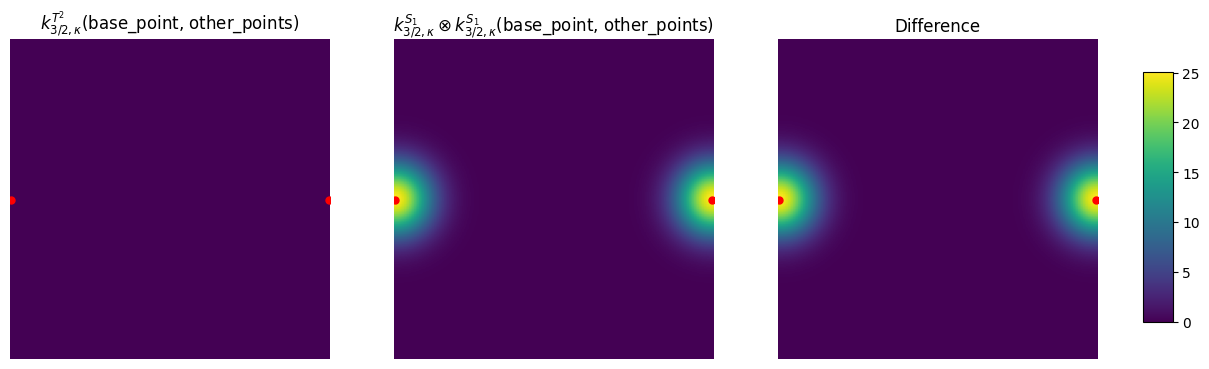

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize= (15, 5), nrows=1, ncols=3)

cmap = plt.get_cmap('viridis')

# find common range of values
product_minmin_vis_32 = np.min([np.min(kernel_vals_32), np.min(product_kernel_vals_32)])
product_maxmax_vis_32 = np.max([np.max(kernel_vals_32), np.max(product_kernel_vals_32)])

ax1.imshow(        kernel_vals_32.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_32, vmax=product_maxmax_vis_32, cmap=cmap)
ax2.imshow(product_kernel_vals_32.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_32, vmax=product_maxmax_vis_32, cmap=cmap)
ax3.imshow(       product_diff_32.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_32, vmax=product_maxmax_vis_32, cmap=cmap)


# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

# plot the base point
ax1.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax2.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax3.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)

ax1.set_title(r'$k_{3/2, \kappa}^{T^2}($base_point, other_points$)$')
ax2.set_title('$k_{3/2, \kappa}^{S_1} \otimes k_{3/2, \kappa}^{S_1}($base_point, other_points$)$')
ax3.set_title('Difference')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=product_minmin_vis_32, vmax=product_maxmax_vis_32))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

We see that the `kernel` differs from the `product_kernel`, despite having the same parameters.

TODO: this is supposed to start working after normalization gets introduced.

We visualize the `kernel` and `product_kernel` for $\nu = \infty$ as well as the differnce between them.

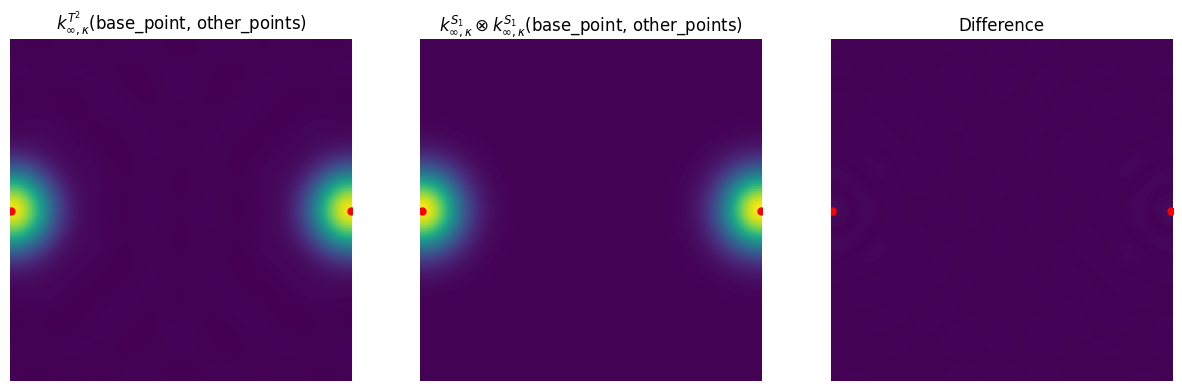

In [17]:
ig, (ax1, ax2, ax3) = plt.subplots(figsize= (15, 5), nrows=1, ncols=3)

cmap = plt.get_cmap('viridis')

# find common range of values
product_minmin_vis_inf = np.min([np.min(kernel_vals_inf), np.min(product_kernel_vals_inf)])
product_maxmax_vis_inf = np.max([np.max(kernel_vals_inf), np.max(product_kernel_vals_inf)])

ax1.imshow(        kernel_vals_inf.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_inf, vmax=product_maxmax_vis_inf, cmap=cmap)
ax2.imshow(product_kernel_vals_inf.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_inf, vmax=product_maxmax_vis_inf, cmap=cmap)
ax3.imshow(       product_diff_inf.reshape(_NUM_PTS, _NUM_PTS), vmin=product_minmin_vis_inf, vmax=product_maxmax_vis_inf, cmap=cmap)


# Remove axis
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

# plot the base point
ax1.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax2.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)
ax3.scatter(x=[0, _NUM_PTS-1], y=[_NUM_PTS//2, _NUM_PTS//2], c='r', s=25)


ax1.set_title(r'$k_{\infty, \kappa}^{T^2}($base_point, other_points$)$')
ax2.set_title('$k_{\infty, \kappa}^{S_1} \otimes k_{\infty, \kappa}^{S_1}($base_point, other_points$)$')
ax3.set_title('Difference')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=product_minmin_vis_inf, vmax=product_maxmax_vis_inf))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

We see that the `kernel` and the `product_kernel` are the same in this case, as theory predicts.

TODO: this is supposed to start working after normalization gets introduced.